In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from scipy import optimize

In [34]:
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100

def generate_batch_bipolar(n, mu=0.5, sigma=0.2):
    """ Two gaussian clouds on each side of the origin """
    x_ = np.random.normal(mu, sigma, (n, nFeatures))
    # yB in {0, 1}
    y_b = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y1 = 2. * y_b - 1
    x_ *= y1[:, np.newaxis]
    x_ -= x_.mean(axis=0)
    return x_, y1

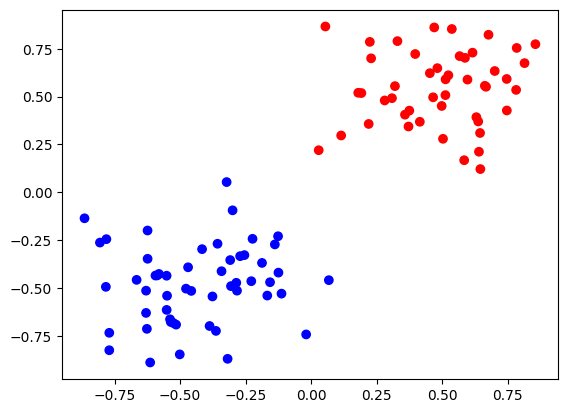

In [48]:
X, y = generate_batch_bipolar(N, mu=.5, sigma=.22)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

In [49]:
class MaxMarginClassifier:
    def __init__(self):
        self.alpha = None
        self.w = None
        self.support_vectors = None
        self.intercept = None

    def fit(self, x_, y_1):
        yx = y_1[:, np.newaxis] * x_ # yX

        # Gram matrix of (yX)
        gram_yx = np.matmul(yx, yx.T)

        # Lagrange dual problem
        def lagrange_dual(g, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(g)) # equation 8
        def lagrange_dual_alpha(g, alpha):
            return np.ones_like(alpha) - alpha.dot(g)
        identity = np.eye(N)
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: np.dot(identity, a), 'jac': lambda a: identity})

        # Maximizing by 'Minimizing' the opposite
        opt_res = optimize.minimize(fun=lambda a: -lagrange_dual(gram_yx, a),
                                   x0=np.zeros(N),
                                   method='SLSQP',
                                   jac=lambda a: -lagrange_dual_alpha(gram_yx, a),
                                   constraints=constraints)
        self.alpha = opt_res.x
        self.w = np.sum((self.alpha[:, np.newaxis] * yx), axis=0) # equation 6
        epsilon = 1e-6
        self.support_vectors = X[self.alpha > epsilon]

        # Support vectors are at a distance <= 1 to the separation hyperplane
        neg_support_vec = max(np.dot(self.support_vectors[np.dot(self.support_vectors, self.w) < 0], self.w))
        pos_support_vec = min(np.dot(self.support_vectors[np.dot(self.support_vectors, self.w) >= 0], self.w))
        self.intercept = -(neg_support_vec + pos_support_vec)/2 # equation 9


    def predict(self, x_):
        assert(self.w is not None)
        assert(self.w.shape[0] == x_.shape[1])
        return 2 * (np.matmul(x_, self.w) > 0) - 1

In [50]:
model = MaxMarginClassifier()
model.fit(X, y)
model.w, model.intercept

(array([4.18419389, 3.18450266]), np.float64(0.17914199636380895))

In [53]:
def plot_line(ax, x_range, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (x_range - x0[0]) + x0[1]
    ax.plot(x_range, yy, color=color, label=label, linestyle=linestyle)

def plotSvm(X, y, supportVectors=None, w=None, intercept=0., label='Data', separatorLabel='Separator',
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)

    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)

    if supportVectors is not None:
        ax.scatter(supportVectors[:,0], supportVectors[:,1], label='SupportVector', s=80, facecolors='none',
                   edgecolors='gold', color='gold')
        print(f"Number of support vectors = {len(supportVectors)}")

    if w is not None:
        xx = np.array(bound[0])
        plot_line(ax, xx, w, intercept, separatorLabel) # Plotting the optimal margin
        # Plotting the positive and negative margins
        if supportVectors is not None:
            signed_dist = np.matmul(supportVectors, w)
            margin = 2. / np.linalg.norm(w) # M = 2. / ||w||

            support_max_neg = supportVectors[np.argmin(signed_dist)]
            support_max_pos = supportVectors[np.argmax(signed_dist)]

            plot_line(ax, xx, w, support_max_neg, 'Margin -', linestyle='-.', alpha=0.8)
            plot_line(ax, xx, w, support_max_pos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % margin)

    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])

Number of support vectors = 3


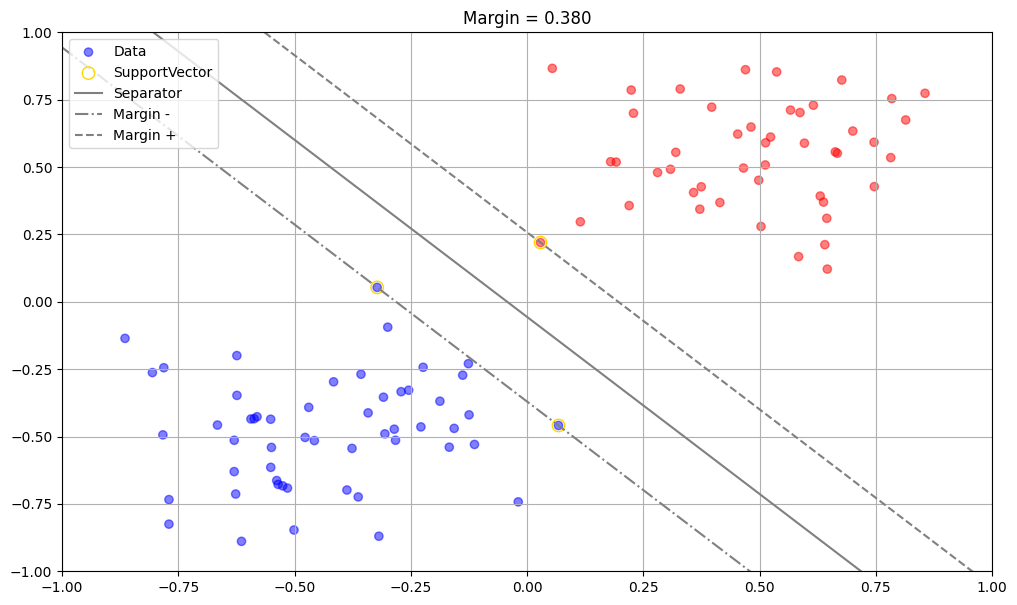

In [54]:

fig, ax = plt.subplots(1, figsize=(12, 7))
plotSvm(X, y, model.support_vectors, model.w, model.intercept, ax=ax)